In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [71]:
EXTRA_SMALL_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [72]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=EXTRA_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=EXTRA_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [73]:
# https://data.humdata.org/dataset/c87c4508-9caf-4959-bf06-6ab4855d84c6
df = pd.read_csv('../../datasets/owid-covid-data.csv', usecols=['location', 'date', 'total_cases', 'total_tests','total_tests_per_thousand'])
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= np.datetime64('2020-01-01')]
df['positive_rate'] = df['total_cases'] / df['total_tests']
df = df[(df['location'] != 'International') & (df['location'] != 'World')]

In [74]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

In [75]:
df_flights = pd.read_csv('../../datasets/edge_lists/edge_list_processed_all-Canada.txt', names=['date', 'From', 'To', 'number of flights'])
df_flights['date'] = pd.to_datetime(df_flights['date'])
df_flights

,date,From,To,number of flights
0,2020-01-02,Canada,Canada,169
1,2020-01-02,United Kingdom,Canada,1
2,2020-01-02,Canada,US,6
3,2020-01-02,Japan,Canada,2
4,2020-01-02,Canada,Cuba,1
...,...,...,...,...
5948,2020-09-25,Canada,US,4
5949,2020-09-25,Saint Pierre and Miquelon,Canada,1
5950,2020-09-25,China,Canada,1
5951,2020-09-25,"Korea, South",Canada,1


In [76]:
PROVINCES = ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Northwest Territories', 'Yukon', 'Nunavut']

In [77]:
NAME_CONVERSION = {"United States": "US",
                   "South Korea": "Korea, South",
                   "Taiwan": "Taiwan*",
                   "Czech Republic": "Czechia",
                   "Bosnia and Herzegovina": "Bosnia And Herzegovina"}
BLACKLIST1 = {"Saint Pierre and Miquelon", "Martinique", "Turkmenistan", "North Macedonia", "Guadeloupe", "Marshall Islands"}

In [78]:
df.loc[df['total_tests'].isnull(), 'total_cases'] = 0.0

In [79]:
# Countries without test data
BLACKLIST2 = set()
for node in df['location'].unique():
    df_node = df[df['location']==node]
    if df_node[~np.isnan(df_node['positive_rate'])].empty:
        BLACKLIST2.add(node)  
    else:
        for idx, date in enumerate(df_node['date']):
            if df_node['total_cases'].iloc[idx] >= df_node['total_tests'].iloc[idx]:
                print(node)
                BLACKLIST2.add(node)
                break
# list(BLACKLIST2)

Peru
Sri Lanka


In [80]:
def remove_flights_blacklist(df_flights):
    for destination in pd.concat([df_flights['From'], df_flights['To']]).unique():
        if destination in BLACKLIST1 or destination in BLACKLIST2:
            df_flights = df_flights[df_flights['From'] != destination]
            df_flights = df_flights[df_flights['To'] != destination]
    return df_flights

In [81]:
df_flights = remove_flights_blacklist(df_flights)

In [82]:
def remove_test_blacklist(df):
    for destination in df['location'].unique():
        if destination in BLACKLIST2:
            df = df[df['location'] != destination]
    return df

In [83]:
df = remove_test_blacklist(df)

In [84]:
def convert_country_region_names(df, NAME_CONVERSION):
    for key in NAME_CONVERSION.keys():
        df = df.replace({key: NAME_CONVERSION[key]})
    return df

In [85]:
df = convert_country_region_names(df, NAME_CONVERSION)

In [86]:
def assert_country_in_flight_data_has_corresponding_test_rate(df_flights, df):
    for destination in pd.concat([df_flights['From'], df_flights['To']]).unique():
        if destination not in df['location'].unique() and destination not in PROVINCES:
            print("Not found:", destination)

In [87]:
assert_country_in_flight_data_has_corresponding_test_rate(df_flights, df)

In [88]:
def compute_avg(df):
    dates = sorted(df['date'].unique())
    avg_total_tests = []
    avg_pos_rates = []
    epsilon = 1e6
    for date in dates:
        df_by_date = df[df['date'] == date]
        avg_total_test = df_by_date["total_tests_per_thousand"].mean(axis=0)
        avg_pos_rate = df_by_date["total_cases"].fillna(0).sum(axis=0) / (df_by_date["total_tests"].fillna(0).sum(axis=0) + epsilon)
        avg_total_tests.append(avg_total_test)
        avg_pos_rates.append(avg_pos_rate)
    return avg_total_tests, avg_pos_rates

avg_total_tests, avg_pos_rates = compute_avg(df)

In [89]:
new_df = pd.DataFrame()
new_df['date'] = sorted(df['date'].unique())
new_df['location'] = "Average"
new_df['positive_rate'] = avg_pos_rates
new_df["total_tests_per_thousand"] = avg_total_tests
df = df.append(new_df)
df

,location,date,total_cases,total_tests,total_tests_per_thousand,positive_rate
1420,Argentina,2020-02-11,NaN,2.0,0.000000,NaN
1421,Argentina,2020-02-12,0.0,NaN,NaN,NaN
1422,Argentina,2020-02-13,0.0,NaN,NaN,NaN
1423,Argentina,2020-02-14,0.0,NaN,NaN,NaN
1424,Argentina,2020-02-15,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
252,Average,2020-09-09,NaN,NaN,122.628914,0.055227
253,Average,2020-09-10,NaN,NaN,130.823370,0.039071
254,Average,2020-09-11,NaN,NaN,108.948400,0.044393
255,Average,2020-09-12,NaN,NaN,NaN,0.000000


In [90]:
r1 = df[(df['location'] == 'Canada') & (df['date'] == np.datetime64('2020-03-22'))]['total_tests_per_thousand'].iloc[0]
r1

2.6180000000000003

In [91]:
r2 = df[(df['location'] == 'Canada') & (df['date'] == np.datetime64('2020-06-01'))]['total_tests_per_thousand'].iloc[0]
r2

44.812

In [92]:
"{:.3f}%".format((r2 - r1)/r1 * 100)

'1611.688%'

In [93]:
df['location'].unique()

array(['Argentina', 'Australia', 'Austria', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria', 'Canada',
       'Chile', 'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'Germany',
       'Ghana', 'Greece', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malawi', 'Malaysia', 'Maldives', 'Malta', 'Mexico',
       'Morocco', 'Mozambique', 'Myanmar', 'Nepal', 'Netherlands',
       'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
       'Paraguay', 'Philippines', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Singapore', 'Slovakia', 'Slovenia', 'South Africa',
       'Korea, South', 'Spain', 'Switzerlan

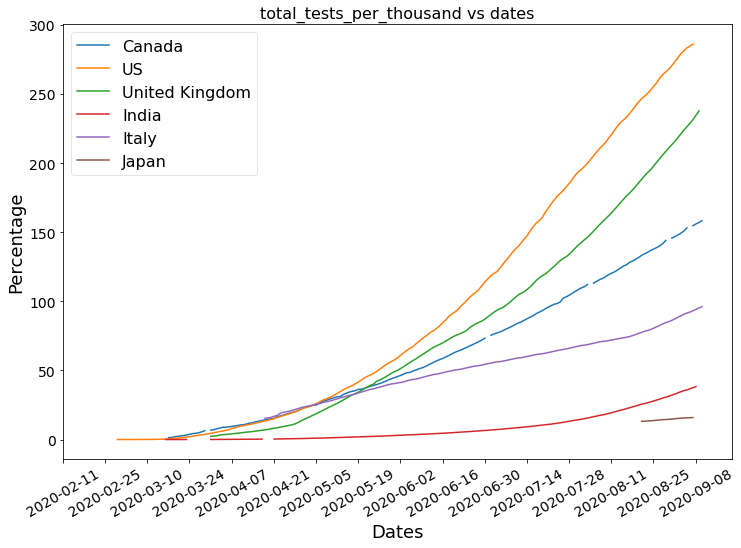

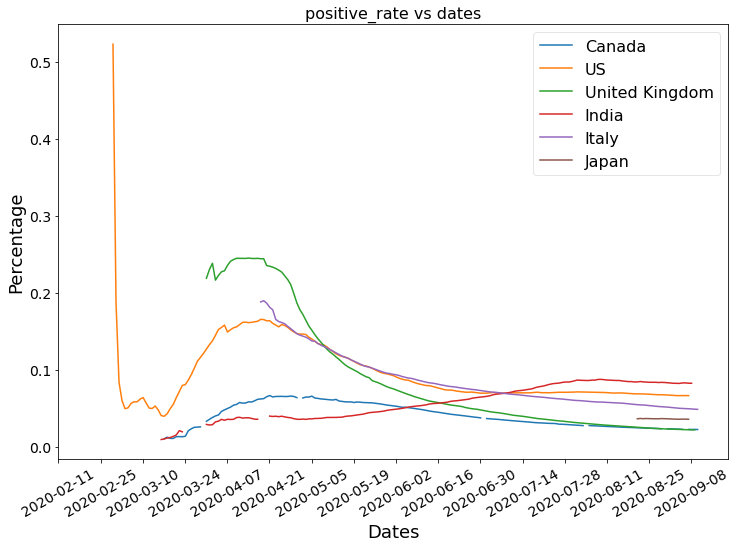

In [94]:
def plot_rates(target_countries, df, label, title):
    fig = plt.figure(facecolor='w', figsize=(12, 8))
    ax = fig.add_subplot(111)
    for c in target_countries:
        rate = df[df['location'] == c][label].to_list()
        date = df[df['location'] == c]['date']
        ax.plot(date, rate, label=c)
    ax.set_xlabel('Dates')
    ax.set_ylabel('Percentage')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=30)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(title)

target_countries = ['Canada', 'US', 'United Kingdom', 'India', 'Italy', 'Japan']
plot_rates(target_countries, df, "total_tests_per_thousand", "total_tests_per_thousand vs dates")
plot_rates(target_countries, df, "positive_rate", "positive_rate vs dates")

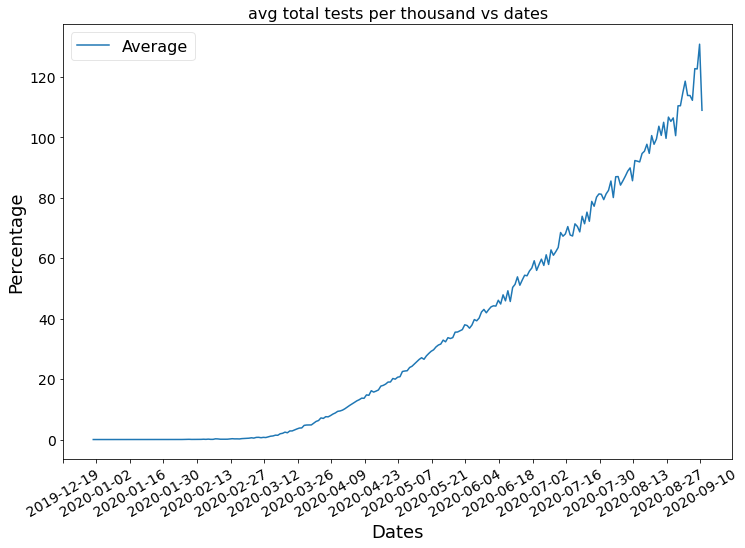

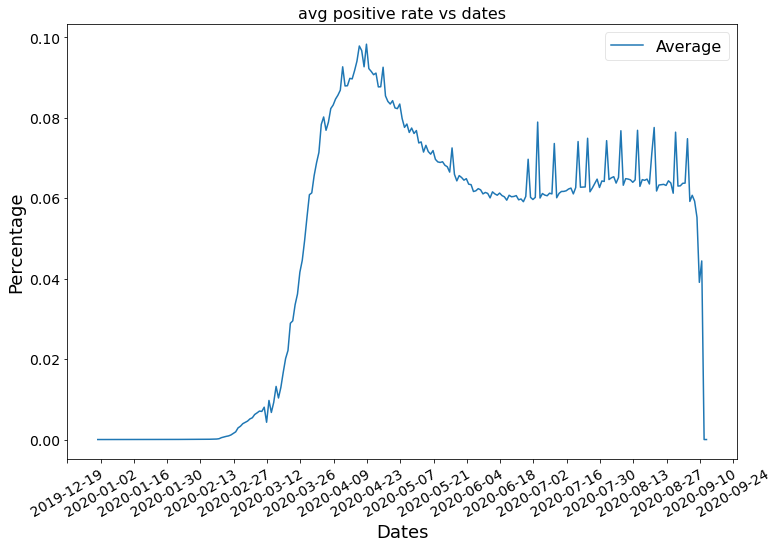

In [95]:
plot_rates(['Average'], df, "total_tests_per_thousand", "avg total tests per thousand vs dates")
plot_rates(['Average'], df, "positive_rate", "avg positive rate vs dates")

In [96]:
df.to_csv('../../datasets/test-rate-processed.csv', index=False, columns=["location", "date", "positive_rate"], header=False)